Rough한 코드

Utils 

In [1]:
# basic module
import os, sys, copy

# data handling / io
import io
import numpy as np
import pandas as pd
import json, base64

# image handling
from PIL import Image, ImageDraw, ImageFont
import cv2
import torch

# LLM
from openai import OpenAI
from PIL import Image, ImageDraw, ImageFont

# Utils
from tqdm import tqdm
import time, argparse, logging, uuid
from dotenv import load_dotenv
from pathlib import Path

# 환경 변수 로드
load_dotenv()

True

In [2]:
# project root 
def find_project_root(marker_filename=".project-root"):
    current_dir = os.path.abspath(os.getcwd())
    while True:
        if os.path.isfile(os.path.join(current_dir, marker_filename)):
            return current_dir
        parent_dir = os.path.dirname(current_dir)
        if parent_dir == current_dir:
            raise FileNotFoundError(f"Could not find {marker_filename} in any parent directory.")
        current_dir = parent_dir
        
# 경로/출력 폴더 생성(find_project_root() 호출 후 사용)
def ensure_dir(path):
    # 디렉토리 없으면 생성
    os.makedirs(path, exist_ok=True)

def get_project_path(*paths):
    project_root = os.getcwd()    # or use a specific absolute path if needed
    return os.path.join(project_root, *paths)

In [3]:
# b64 encoder: jpg image -> base64 string / VLM API
def encode_image_to_base64(
    img_path,
    jpeg_quality: int = 85,
    max_size: int | None = 1024,   # None이면 리사이즈 안 함
):
    """
    - PNG 입력 시 → RGB JPEG로 변환 후 base64 인코딩
    - JPEG 입력 시 → 그대로 (필요하면 리사이즈)
    - max_size: 한 변 최대 길이 (planning/VLM 단계용)
    """
    try:
        img_path = Path(img_path)
        img = Image.open(img_path)

        # PNG / RGBA → RGB
        if img.mode in ("RGBA", "LA", "P"):
            img = img.convert("RGB")

        if max_size is not None:
            img.thumbnail((max_size, max_size))

        buf = io.BytesIO()

        # PNG면 JPEG로 변환
        if img_path.suffix.lower() == ".png":
            img.save(
                buf,
                format="JPEG",
                quality=jpeg_quality,
                optimize=True,
            )
        else:
            # jpg / jpeg 등
            img.save(
                buf,
                format="JPEG",
                quality=jpeg_quality,
                optimize=True,
            )

        buf.seek(0)
        return base64.b64encode(buf.read()).decode("utf-8")

    except Exception as e:
        print(f"Error encoding image: {e}")
        return None


1. VQA
<br> input: error image + user image + user request + prompt_VQA
<br> &nbsp;&nbsp;&nbsp;&nbsp;prompt_VQA:
<br> LLM-VQA 호출 및 첫번째 응답 파싱
<br> output: 요청과 이미지를 보고 판단한 내용


In [ ]:
# tag parser

import json
import re
from typing import Any, Dict, Tuple

_TAG_RE = re.compile(
    r"<(?P<tag>analysis_log|plan_json)>(?P<body>[\s\S]*?)</(?P=tag)>",
    re.IGNORECASE,
)

def parse_tagged_output(text: str) -> Tuple[str, Dict[str, Any]]:
    """
    LLM 응답에서 <analysis_log>와 <plan_json>을 추출하고,
    plan_json은 JSON으로 파싱해서 dict로 반환.
    """
    text = (text or "").strip()
    matches = {m.group("tag").lower(): m.group("body").strip() for m in _TAG_RE.finditer(text)}

    if "analysis_log" not in matches:
        raise ValueError("응답에 <analysis_log>...</analysis_log> 태그가 없습니다.")
    if "plan_json" not in matches:
        raise ValueError("응답에 <plan_json>...</plan_json> 태그가 없습니다.")

    analysis_log = matches["analysis_log"]
    plan_json_str = matches["plan_json"]

    try:
        plan = json.loads(plan_json_str)
    except json.JSONDecodeError as e:
        raise ValueError(f"<plan_json> 내부 JSON 파싱 실패: {e}\n\nJSON:\n{plan_json_str}")

    return analysis_log, plan


In [5]:
# LLM-VQA 호출 및 첫번째 응답 파싱

from typing import Optional, Union
from anthropic import Anthropic

def model_response_anthropic(
    anthropic_client: Anthropic,
    prompt_text: str,
    model: str = "claude-3-7-sonnet-20250219",
    temperature: float = 0.1,
    max_tokens: int = 1000,
    parse_tags: bool = True,
    print_log: bool = True,
    # 이미지 입력(선택)
    img_b64: Optional[str] = None,
    media_type: str = "image/png",
) -> Union[str, Dict[str, Any]]:
    """
    Anthropic(Claude) 전용.
    - prompt_text: prompt1 (태그 출력 규칙 포함)
    - img_b64/media_type

    Returns:
      - parse_tags=False: raw string
      - parse_tags=True: dict {"raw": str, "analysis_log": str, "plan": dict}
    """
    # content 파트 구성
    content = [{"type": "text", "text": prompt_text}]

    if img_b64 is not None:
        content.append({
            "type": "image",
            "source": {
                "type": "base64",
                "media_type": media_type,
                "data": img_b64,
            }
        })

    resp = anthropic_client.messages.create(
        model=model,
        max_tokens=max_tokens,
        temperature=temperature,
        messages=[{"role": "user", "content": content}],
    )

    # Claude 응답은 content blocks로 옴 → text block만 합치기
    raw = "".join(
        blk.text for blk in resp.content
        if getattr(blk, "type", None) == "text"
    ).strip()

    if not parse_tags:
        return raw

    analysis_log, plan = parse_tagged_output(raw)

    if print_log:
        print("\n[analysis_log]\n" + analysis_log)

    return {"raw": raw, "analysis_log": analysis_log, "plan": plan}



확인

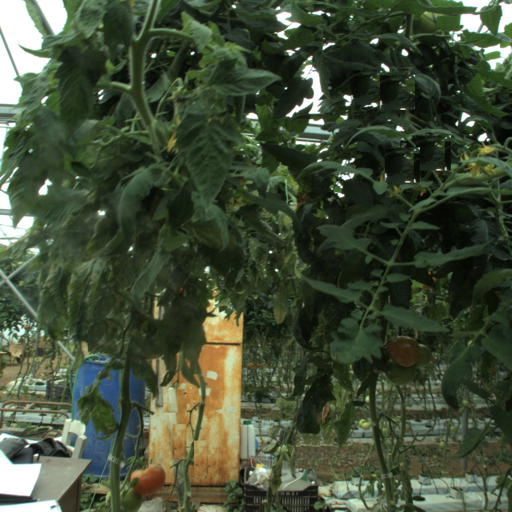

인코딩 문자열의 앞 50자: 
/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAYEBQYFBAYGBQYHBw


In [32]:
# === 1. VQA ===
# 1-1) image, request
    
PROJECT_ROOT = Path(find_project_root())

def get_project_path(*parts):
    return PROJECT_ROOT.joinpath(*parts)

env_path = get_project_path(".env")
img = get_project_path("notebook", "data", "tomato_farm.jpg")
user_request = "semi-ripe 토마토 개수를 세어주세요."
img_b64 = encode_image_to_base64(img, 80, 1024)

display(Image.open(img).resize((512, 512)))
print("인코딩 문자열의 앞 50자: ")
print(img_b64[:50]) 

In [33]:
# 1-2) VQA propmt 
prompt_VQA = f"""
You are an expert vision task planner.

You will be given:
- A user request (Korean)
- ONE image (provided to you as an image input)

Your job in this step is ONLY to analyze the user request and propose a concrete, tool-agnostic plan.
Do NOT run code. Do NOT claim results. Do NOT hallucinate object counts.

User request: {user_request}

Output MUST contain EXACTLY TWO TAGS in this order:
1) <analysis_log> ... </analysis_log>  (Korean, human-readable, step-by-step, short)
2) <plan_json> ... </plan_json>        (machine-readable, MUST be valid JSON)

Rules:
- Do not output anything outside the two tags.
- <analysis_log> should be concise: 5–10 lines, each starting with "Step N:".
- <plan_json> must be STRICT JSON (no trailing commas, no comments, no markdown).

<plan_json> JSON schema:
{{
  "language": "ko",
  "intent_summary": string,
  "task_type": "counting",
  "target_definition": {{
    "primary_object": "tomato",
    "required_attributes": ["red"],
    "exclusions": [string],
    "edge_cases": [string]
  }},
  "subtasks": [
    {{
      "name": string,
      "goal": string,
      "suggested_method": string
    }}
  ],
  "tool_requirements": {{
    "needs_localization": boolean,
    "needs_instance_separation": boolean,
    "needs_attribute_reasoning": boolean,
    "preferred_outputs": [string]
  }},
  "verification_checks": [string],
  "questions_if_ambiguous": [string]
}}
"""

In [34]:
# 1-3) LLM 호출 및 응답 생성, 확인
import os
from anthropic import Anthropic

anthropic_key  = os.getenv("ANTHROPIC_API_KEY")
if not anthropic_key:
    raise RuntimeError("ANTHROPIC_API_KEY가 설정되어 있지 않습니다.")


anthropic_client = Anthropic(api_key=anthropic_key)

out_vqa = model_response_anthropic(
    anthropic_client=anthropic_client,
    prompt_text=prompt_VQA,
    model="claude-sonnet-4-20250514",
    max_tokens=1200,
    temperature=0.2,
    parse_tags=True,
    print_log=True,
    img_b64=img_b64,    
    media_type="image/jpeg", 
)

vqa = out_vqa["plan"]


[analysis_log]
Step 1: 사용자가 semi-ripe 토마토의 개수를 세어달라고 요청했습니다.
Step 2: 이미지에서 토마토 식물들이 자라고 있는 온실이나 재배 공간을 확인했습니다.
Step 3: Semi-ripe는 반숙 상태로, 완전히 빨갛지 않고 부분적으로 색이 변한 토마토를 의미합니다.
Step 4: 잎사귀가 많아 토마토 열매들이 부분적으로 가려져 있어 정확한 탐지가 필요합니다.
Step 5: 녹색, 주황색, 부분적으로 빨간 토마토들을 구분하여 semi-ripe만 식별해야 합니다.
Step 6: 개별 토마토 인스턴스를 분리하고 성숙도를 판단하는 속성 분석이 필요합니다.


2. Plan
<br> input: error image + user request + LLM-VQA 응답 + prompt_plan
<br> &nbsp;&nbsp;&nbsp;&nbsp; prompt_plan: tuned for smartfam environment(tool list 포함)
<br> LLM-plan 호출 및 첫번째 응답 파싱
<br> output: tool list에서 tool 선택 후의 계획


In [9]:
import importlib, inspect
from typing import Any, Dict, List

def load_visionagent_tools_strict() -> List[Dict[str, Any]]:
    mod = importlib.import_module("vision_agent.tools.tools")
    tools: List[Dict[str, Any]] = []

    for name, obj in inspect.getmembers(mod):
        if not inspect.isfunction(obj) or name.startswith("_"):
            continue

        # 1) tools.py에 "정의된" 함수만 (재export된 표준함수 제거)
        if getattr(obj, "__module__", None) != mod.__name__:
            continue

        doc = inspect.getdoc(obj) or ""

        # 2) '... is a tool' 패턴만 통과 (유틸 제거)
        #    (원하면 조건 완화 가능)
        if " is a tool" not in doc:
            continue

        tools.append({
            "name": name,
            "qualname": f"{mod.__name__}.{name}",
            "type": "function",
            "signature": str(inspect.signature(obj)),
            "doc": doc,
        })

    return tools


In [10]:
def format_tool_desc(
    tools: List[Dict[str, Any]],
    max_tools: int = 50,
    max_doc_chars: int = 300,
) -> str:
    lines = []
    for t in tools[:max_tools]:
        lines.append(
            f"- {t['name']} ({t['type']})\n"
            f"  qualname: {t['qualname']}\n"
            f"  signature: {t['signature']}\n"
            f"  doc: {t['doc'][:max_doc_chars].replace('\\n', ' ')}"
        )
    return "\n".join(lines)


In [50]:
planner_state = {
    "observations": [],   # tool 결과 누적
    "turn": 0,
}

In [ ]:
planner_state["observations"].append({
    "tool": tool_name,
    "ok": True,
    "result": result,
    "error": None,
})

In [61]:
def add_observation(tool: str, params: dict, result, ok: bool = True, error: str | None = None):
    planner_state["observations"].append({
        "tool": tool,
        "parameters": params,
        "ok": ok,
        "result": result,
        "error": error,
    })

In [51]:
# prompt_plan TEMPLATE (주의: f-string 아님)
PROMPT_PLAN_TEMPLATE = """
You are a VisionAgent-style planner/controller.

Your job is to decide the NEXT ACTION(s) to take using the available tools, based on the user's request and the accumulated evidence. You do NOT execute tools. You only output tool calls or the final answer.

You will be given:
- A user request (Korean)
- ONE image (already annotated with detection boxes/labels overlaid)
- Tool list with available actions
- VQA log: chronological reasoning, detection notes, bounding-box/label evaluations, and any prior validation outcomes
- VQA structured JSON summary of the detection/analysis results
- Prior tool observations may also appear in the conversation history (as "observation").

Primary evidence:
- Build decisions primarily from [VQA_LOG] and [VQA_STRUCT_JSON].
- Do NOT hallucinate new detections, boxes, or attributes beyond the provided evidence and tool outputs.

User request (Korean):
{user_request}

[VQA_LOG]
{vqa_log}

[VQA_STRUCT_JSON]
{vqa_struct_json}

[TOOLS]
{tool_desc}

[OBSERVATIONS]
{observations}

────────────────────────────────
CORE CONTROL LOOP BEHAVIOR
────────────────────────────────
At each turn, output either:
(A) Tool calls for the NEXT immediate actions (one or more tool calls), OR
(B) A final answer if no more tools are needed.

Do NOT output a full end-to-end plan. Do NOT output steps[1..N].
The executor will run your tool calls in the order you provide, append observations, and call you again with updated context.

────────────────────────────────
DETECTION-SPECIFIC BEHAVIOR
────────────────────────────────
- The image is already annotated. Prefer verification of existing detections.
- If bounding-box coordinates are available in VQA_STRUCT_JSON, use them for cropping and verification.
- If bounding-box coordinates are NOT available, do NOT guess. Request the annotation file
  (COCO JSON / YOLO TXT / model output JSON) or propose a concrete method to obtain coordinates.

Hard rule:
- If VQA_STRUCT_JSON contains bbox coordinates, you MUST call the crop tool first for those boxes.
- You MUST NOT call any VQA tool before attempting crop-based verification when bbox coordinates exist.
- VQA tools are allowed ONLY if bbox coordinates are missing/unavailable OR cropping fails with an error.

────────────────────────────────
OUTPUT FORMAT (STRICT)
────────────────────────────────
Output MUST contain EXACTLY TWO tags in this exact order:
1) <analysis_log> ... </analysis_log>
2) <plan_json> ... </plan_json>

Do NOT output anything outside the two tags.

<analysis_log> rules:
- 3–7 lines only
- Each line must start with "Step N:"
- Only describe the immediate reasoning for the NEXT action(s), not a full multi-step plan.

<plan_json> rules:
- MUST be STRICT JSON (no trailing commas, no comments, no markdown)
- Must match exactly one of the following schemas:

Schema 1: Tool calls
{{
  "language": "ko",
  "mode": "tool_calls",
  "selected_tools": [string],
  "tool_calls": [
    {{
      "id": int,
      "tool": string,
      "parameters": object,
      "expected_result": string
    }}
  ],
  "open_questions": [string]
}}

Schema 2: Final answer
{{
  "language": "ko",
  "mode": "final",
  "final_answer": string,
  "open_questions": [string]
}}

Additional rules:
- tool_calls must be listed in exact execution order; ids must start at 1 and increase strictly by 1 within this turn.
- Each tool call MUST reference a tool name from [TOOLS].
- Keep tool_calls minimal: only what is needed before the next observation.
- If you need missing inputs (e.g., box coordinates), set mode="final" and clearly request them in final_answer, or set open_questions accordingly.
"""


In [52]:
def render_prompt(user_request: str, vqa_log: str, vqa_struct: dict, tool_desc: str) -> str:
    vqa_struct_json = json.dumps(vqa_struct, ensure_ascii=False, indent=2)

    # observations는 너무 길어질 수 있으니, 필요하면 truncate 가능
    if planner_state["observations"]:
        obs_text = json.dumps(planner_state["observations"], ensure_ascii=False, indent=2)
    else:
        obs_text = "(none)"

    return PROMPT_PLAN_TEMPLATE.format(
        user_request=user_request,
        vqa_log=vqa_log,
        vqa_struct_json=vqa_struct_json,
        tool_desc=tool_desc,
        observations=obs_text,
    )

In [53]:
def validate_plan(plan: dict, tools_meta: list[dict]) -> None:
    names = {t["name"] for t in tools_meta}
    mode = plan.get("mode")
    if mode not in ("tool_calls", "final"):
        raise ValueError(f"Invalid mode: {mode}")

    if mode == "tool_calls":
        for tc in plan.get("tool_calls", []):
            if tc.get("tool") not in names:
                raise ValueError(f"Unknown tool in plan: {tc.get('tool')}")


In [55]:
def plan_once(user_request: str, vqa_log: str, vqa_struct: dict, tool_desc: str, img_b64: str):
    prompt_text = render_prompt(user_request, vqa_log, vqa_struct, tool_desc)

    out_plan = model_response_anthropic(
        anthropic_client=anthropic_client,
        prompt_text=prompt_text,
        model="claude-sonnet-4-20250514",
        max_tokens=1400,
        temperature=0.2,
        parse_tags=True,
        print_log=True,
        img_b64=img_b64,
        media_type="image/jpeg",
    )

    analysis_log = out_plan["analysis_log"]
    plan_json = out_plan["plan"]
    return analysis_log, plan_json


---

* 확인

In [35]:
# === 2. Plan ===
# 2-1) input

vqa_log = out_vqa["analysis_log"]
vqa_struct = out_vqa["plan"]

# vqa_struct를 JSON 형태로 보기 좋게 출력
print("=" * 60)
print("[VQA Plan Structure (JSON)]")
print("=" * 60)
print(json.dumps(vqa_struct, indent=2, ensure_ascii=False))

[VQA Plan Structure (JSON)]
{
  "language": "ko",
  "intent_summary": "토마토 식물에서 반숙 상태의 토마토 개수 세기",
  "task_type": "counting",
  "target_definition": {
    "primary_object": "tomato",
    "required_attributes": [
      "semi-ripe",
      "partially_red",
      "orange_to_red_transition"
    ],
    "exclusions": [
      "fully_green_tomatoes",
      "fully_red_tomatoes",
      "leaves",
      "stems"
    ],
    "edge_cases": [
      "partially_occluded_tomatoes",
      "tomatoes_in_shadow",
      "small_developing_fruits"
    ]
  },
  "subtasks": [
    {
      "name": "tomato_detection",
      "goal": "이미지에서 모든 토마토 열매 탐지",
      "suggested_method": "object_detection_with_localization"
    },
    {
      "name": "ripeness_classification",
      "goal": "각 토마토의 성숙도 분류 (green/semi-ripe/ripe)",
      "suggested_method": "color_analysis_and_attribute_classification"
    },
    {
      "name": "semi_ripe_filtering",
      "goal": "semi-ripe 상태의 토마토만 필터링",
      "suggested_method": "attribute_b

In [13]:
# 2-2) tool list
tools = load_visionagent_tools_strict()
tool_desc = format_tool_desc(tools, max_tools=80, max_doc_chars=350)
print("Loaded tools:", len(tools))
# print(tool_desc)
print("qwen" in tool_desc.lower())

Loaded tools: 37
True


In [12]:
# 2-3) tool list 추가: detected_image_crop 

from __future__ import annotations

import json
import os
from typing import Any, Dict, List, Optional, Tuple

from PIL import Image, ImageOps

def crop_to_b64(pil_img: Image.Image) -> str:
    import base64
    from io import BytesIO
    buf = BytesIO()
    pil_img.save(buf, format="JPEG")
    return base64.b64encode(buf.getvalue()).decode("utf-8")


def _clamp_box_xyxy(
    bx: List[float],
    img_w: int,
    img_h: int,
) -> Optional[Tuple[int, int, int, int]]:
    if len(bx) != 4:
        return None
    x1, y1, x2, y2 = [int(round(v)) for v in bx]

    # reorder
    if x1 > x2:
        x1, x2 = x2, x1
    if y1 > y2:
        y1, y2 = y2, y1

    # clamp (note: allow x2==img_w, y2==img_h for PIL crop upper bounds)
    x1 = max(0, min(x1, img_w - 1))
    y1 = max(0, min(y1, img_h - 1))
    x2 = max(1, min(x2, img_w))
    y2 = max(1, min(y2, img_h))

    if x2 <= x1 or y2 <= y1:
        return None
    return x1, y1, x2, y2


def detected_image_crop_tool(
    full_image_path: str,
    detections_json: str,
    out_dir: Optional[str] = None,
    return_b64: bool = True,
    save_jpg: bool = False,
) -> Dict[str, Any]:
    """
    VisionAgent tool: crop detected regions from an image.

    Inputs:
      - full_image_path: str
      - detections_json: JSON string of list[{"id": <str|int>, "bbox": [x1,y1,x2,y2]}]
      - out_dir: optional dir (used only when save_jpg=True)
      - return_b64: include base64 in outputs
      - save_jpg: save crop jpg files

    Output (JSON-serializable dict):
      {
        "ok": bool,
        "image_size": {"w": int, "h": int},
        "num_requested": int,
        "num_cropped": int,
        "crops": [
          {
            "id": ...,
            "bbox": [x1,y1,x2,y2],
            "crop_b64": str | null,
            "crop_path": str | null
          }
        ],
        "skipped": [{"id":..., "reason": str}],
        "error": str | null
      }
    """
    result: Dict[str, Any] = {
        "ok": False,
        "image_size": None,
        "num_requested": 0,
        "num_cropped": 0,
        "crops": [],
        "skipped": [],
        "error": None,
    }

    # Parse detections
    try:
        det_objects = json.loads(detections_json)
        if not isinstance(det_objects, list):
            raise ValueError("detections_json must decode to a list.")
    except Exception as e:
        result["error"] = f"Invalid detections_json: {e}"
        return result

    result["num_requested"] = len(det_objects)

    # Load image
    try:
        full = Image.open(full_image_path)
        full = ImageOps.exif_transpose(full)
        img_w, img_h = full.size
        result["image_size"] = {"w": img_w, "h": img_h}
    except Exception as e:
        result["error"] = f"Failed to load image: {e}"
        return result

    if save_jpg:
        if out_dir is None:
            result["error"] = "out_dir is required when save_jpg=True"
            return result
        os.makedirs(out_dir, exist_ok=True)

    # Crop loop
    for det in det_objects:
        det_id = det.get("id", None)
        bx = det.get("bbox", None)

        if bx is None:
            result["skipped"].append({"id": det_id, "reason": "missing bbox"})
            continue
        if not isinstance(bx, list):
            result["skipped"].append({"id": det_id, "reason": "bbox must be a list"})
            continue

        clamped = _clamp_box_xyxy(bx, img_w, img_h)
        if clamped is None:
            result["skipped"].append({"id": det_id, "reason": "degenerate/invalid bbox"})
            continue

        x1, y1, x2, y2 = clamped
        crop = full.crop((x1, y1, x2, y2))

        crop_b64 = crop_to_b64(crop) if return_b64 else None

        crop_path = None
        if save_jpg:
            crop_path = os.path.join(out_dir, f"crop_{det_id}.jpg")
            crop.save(crop_path, format="JPEG")

        result["crops"].append({
            "id": det_id,
            "bbox": [x1, y1, x2, y2],
            "crop_b64": crop_b64,
            "crop_path": crop_path,
        })

    result["num_cropped"] = len(result["crops"])
    result["ok"] = True
    return result


In [17]:
# 2-3) tool list 추가: detected_image_crop 

import inspect

# 1) tool dict 정의 (formatter 스키마에 맞춤)
DETECTED_IMAGE_CROP_TOOL = {
    "name": "detected_image_crop",
    "qualname": "detected_image_crop_tool",
    "type": "python",  # tools[0]["type"] 값이 뭔지 보고 동일하게 맞추면 더 안전함
    "signature": str(inspect.signature(detected_image_crop_tool)),
    "doc": (
        "Crop regions from an image using provided bbox coords (xyxy). "
        "Inputs: full_image_path(str), detections_json(str: list[{id,bbox:[x1,y1,x2,y2]}]), "
        "out_dir(optional), return_b64(bool), save_jpg(bool). "
        "Outputs: {ok, image_size, num_requested, num_cropped, crops[], skipped[], error}."
    ),

    # (선택) formatter는 안 읽지만, 너의 다른 코드(LLM/function calling)에서 쓸 수 있음
    "parameters": {
        "type": "object",
        "properties": {
            "full_image_path": {"type": "string"},
            "detections_json": {
                "type": "string",
                "description": "JSON string: list of {id, bbox:[x1,y1,x2,y2]} (xyxy)"
            },
            "out_dir": {"type": ["string", "null"]},
            "return_b64": {"type": "boolean", "default": True},
            "save_jpg": {"type": "boolean", "default": False},
        },
        "required": ["full_image_path", "detections_json"],
    },

    # (주의) tools 메타 리스트에는 원래 func가 없었음.
    "func": detected_image_crop_tool,
}

# 2) tools 로드 후, 프롬프트/format 전에 주입
tools = load_visionagent_tools_strict()

# 기존 type 값에 맞추고 싶으면(추천):
# DETECTED_IMAGE_CROP_TOOL["type"] = tools[0]["type"]

# (선택) 중복 방지
tools = [t for t in tools if t.get("name") != "detected_image_crop"]

tools.append(DETECTED_IMAGE_CROP_TOOL)

# 3) 이제 tool_desc 생성 (KeyError 없이 통과)
tool_desc = format_tool_desc(tools, max_tools=80, max_doc_chars=350)

print("Loaded tools:", len(tools))
print("detected_image_crop" in tool_desc.lower())


Loaded tools: 38
True


In [ ]:
# 2-4) prompt_plan TEMPLATE (주의: f-string 아님)
PROMPT_PLAN_TEMPLATE = """
You are a VisionAgent-style planner/controller.

Your job is to decide the NEXT ACTION(s) to take using the available tools, based on the user's request and the accumulated evidence. You do NOT execute tools. You only output tool calls or the final answer.

You will be given:
- A user request (Korean)
- ONE image (already annotated with detection boxes/labels overlaid)
- Tool list with available actions
- VQA log: chronological reasoning, detection notes, bounding-box/label evaluations, and any prior validation outcomes
- VQA structured JSON summary of the detection/analysis results
- Prior tool observations may also appear in the conversation history (as "observation").

Primary evidence:
- Build decisions primarily from [VQA_LOG] and [VQA_STRUCT_JSON].
- Do NOT hallucinate new detections, boxes, or attributes beyond the provided evidence and tool outputs.

User request (Korean):
{user_request}

[VQA_LOG]
{vqa_log}

[VQA_STRUCT_JSON]
{vqa_struct_json}

[TOOLS]
{tool_desc}

[OBSERVATIONS]
{observations}

────────────────────────────────
CORE CONTROL LOOP BEHAVIOR
────────────────────────────────
At each turn, output either:
(A) Tool calls for the NEXT immediate actions (one or more tool calls), OR
(B) A final answer if no more tools are needed.

Do NOT output a full end-to-end plan. Do NOT output steps[1..N].
The executor will run your tool calls in the order you provide, append observations, and call you again with updated context.

────────────────────────────────
DETECTION-SPECIFIC BEHAVIOR
────────────────────────────────
- The image is already annotated. Prefer verification of existing detections.
- If bounding-box coordinates are available in VQA_STRUCT_JSON, use them for cropping and verification.
- If bounding-box coordinates are NOT available, do NOT guess. Request the annotation file
  (COCO JSON / YOLO TXT / model output JSON) or propose a concrete method to obtain coordinates.

Hard rule:
- If VQA_STRUCT_JSON contains bbox coordinates, you MUST call the crop tool first for those boxes.
- You MUST NOT call any VQA tool before attempting crop-based verification when bbox coordinates exist.
- VQA tools are allowed ONLY if bbox coordinates are missing/unavailable OR cropping fails with an error.

────────────────────────────────
OUTPUT FORMAT (STRICT)
────────────────────────────────
Output MUST contain EXACTLY TWO tags in this exact order:
1) <analysis_log> ... </analysis_log>
2) <plan_json> ... </plan_json>

Do NOT output anything outside the two tags.

<analysis_log> rules:
- 3–7 lines only
- Each line must start with "Step N:"
- Only describe the immediate reasoning for the NEXT action(s), not a full multi-step plan.

<plan_json> rules:
- MUST be STRICT JSON (no trailing commas, no comments, no markdown)
- Must match exactly one of the following schemas:

Schema 1: Tool calls
{{
  "language": "ko",
  "mode": "tool_calls",
  "selected_tools": [string],
  "tool_calls": [
    {{
      "id": int,
      "tool": string,
      "parameters": object,
      "expected_result": string
    }}
  ],
  "open_questions": [string]
}}

Schema 2: Final answer
{{
  "language": "ko",
  "mode": "final",
  "final_answer": string,
  "open_questions": [string]
}}

Additional rules:
- tool_calls must be listed in exact execution order; ids must start at 1 and increase strictly by 1 within this turn.
- Each tool call MUST reference a tool name from [TOOLS].
- Keep tool_calls minimal: only what is needed before the next observation.
- If you need missing inputs (e.g., box coordinates), set mode="final" and clearly request them in final_answer, or set open_questions accordingly.
"""


In [60]:
# 1) plan 생성 (render_prompt + plan_once 내부 사용)
analysis_log, plan_struct = plan_once(
    user_request=user_request,
    vqa_log=vqa_log,
    vqa_struct=vqa_struct,
    tool_desc=tool_desc,
    img_b64=img_b64,
)

print("\n" + "=" * 60)
print("[Plan Structure (JSON)]")
print("=" * 60)
print(json.dumps(plan_struct, indent=2, ensure_ascii=False))



[analysis_log]
Step 1: VQA_STRUCT_JSON에서 bbox 좌표가 제공되지 않았으므로 먼저 토마토 탐지를 수행해야 합니다.
Step 2: 이미지에서 토마토 식물이 무성하게 자라고 있어 많은 토마토가 잎사귀에 가려져 있습니다.
Step 3: Semi-ripe 토마토를 정확히 식별하기 위해서는 먼저 모든 토마토를 탐지하고 성숙도를 분석해야 합니다.
Step 4: countgd_object_detection을 사용하여 토마토를 탐지하고, 이후 각 토마토의 성숙도를 분류할 계획입니다.

[Plan Structure (JSON)]
{
  "language": "ko",
  "mode": "tool_calls",
  "selected_tools": [
    "countgd_object_detection"
  ],
  "tool_calls": [
    {
      "id": 1,
      "tool": "countgd_object_detection",
      "parameters": {
        "prompt": "tomato, tomatoes",
        "image": "image",
        "box_threshold": 0.2
      },
      "expected_result": "토마토 열매들의 bounding box 좌표와 탐지 결과를 얻어 semi-ripe 상태 분석을 위한 기초 데이터 확보"
    }
  ],
  "open_questions": [
    "탐지된 토마토들 중 어떤 것이 semi-ripe 상태인지 색상 분석이 필요"
  ]
}


3. Execution
<br> input: 
